# OpenCV Image Classifier for Kitesurfing 

Tracking cameras are getting very popular with extreme sports enthusiast. One example is the [Soloshot](https://shop.soloshot.com/), which is a camera, gimball, and tracking software system that follows a sports player. A similar solution is quadcopter [follow me mode](http://www.dji.com/intelligent-flight-modes#gsSmart) in which the drone will track a moving person. I've been thinking about building a tracking camera for Kitesurfers. As a first step I built an image classifier for kites:

![Kiter riding a hydrofoil with target locked kite](kite-detector-money.png)

This project was more of a heat check than a full blown effort to build a high quality classifier.  I had not tried image classification in several years.  The state of the art has moved quickly in the last few years.  High quality facial [reconigition](https://www.intelli-vision.com/security/face-recognition/) is common.  Human level accuracy on [Image Net](http://image-net.org/) has been achived [recently](https://github.com/KaimingHe/deep-residual-networks).

I did not start with a state-of-the art technique such as a Convolutional Neural Network.  Instead I used the builtin OpenCV classifier which was laying around on my Linux box.  This turned out to be OpenCV 2.4ish.

I used the HAAR clasifier which is described [here](http://docs.opencv.org/2.4/modules/objdetect/doc/cascade_classification.html).  The algorithm consists of a HAAR feature extractor and a cascade classifier.

The classifer is trained on a small image, about 20x20 pixels.  The classifer reports a yes or no indicating if the image contains the object of interest (a kite in this case).

To process a larger image the 20x20 pixel mask is tried out at each location in the larger image and also over a range of image scales.  The size of the mask dictates the smallest feature that can be detected in an image.

The training set for the classifer consist of a small set of positive images and a larger set of negative images that do not contain the object.  The layers of the cascade are trained to first accept all positive images and then to do an increasingly better job of rejecting negative images.


## Dataset

The images in the dataset came from my phone.  I like to kitesurf and have quite a few photos of kites.  Let's look at a sample of the raw images.

The raw images show some of the challenges in this task.  Kites can be large or small features.  There can be multiple kites in an image.  Some pictures are upside down.

In [2]:
# Setup and utility routines
import numpy as np
import matplotlib.pyplot as plt
import cv2
import urllib

%matplotlib inline

def raw_images_url(url, filenames):
    images = []
    for filename in filenames:
        img_url = url % filename
        resp = urllib.urlopen(img_url)
        image = np.asarray(bytearray(resp.read()), dtype="uint8")
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        images.append(image)
    return images    

def show_images(cols, url, filenames):    
    images = raw_images_url(s3_url, filenames)
    rows = (len(images) / cols) + 1 
    for i in range(len(images)):
        plt.subplot(rows, cols, i + 1)
        img = images[i]
        img_to_plt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_to_plt)
        plt.axis('off')    
    plt.show()

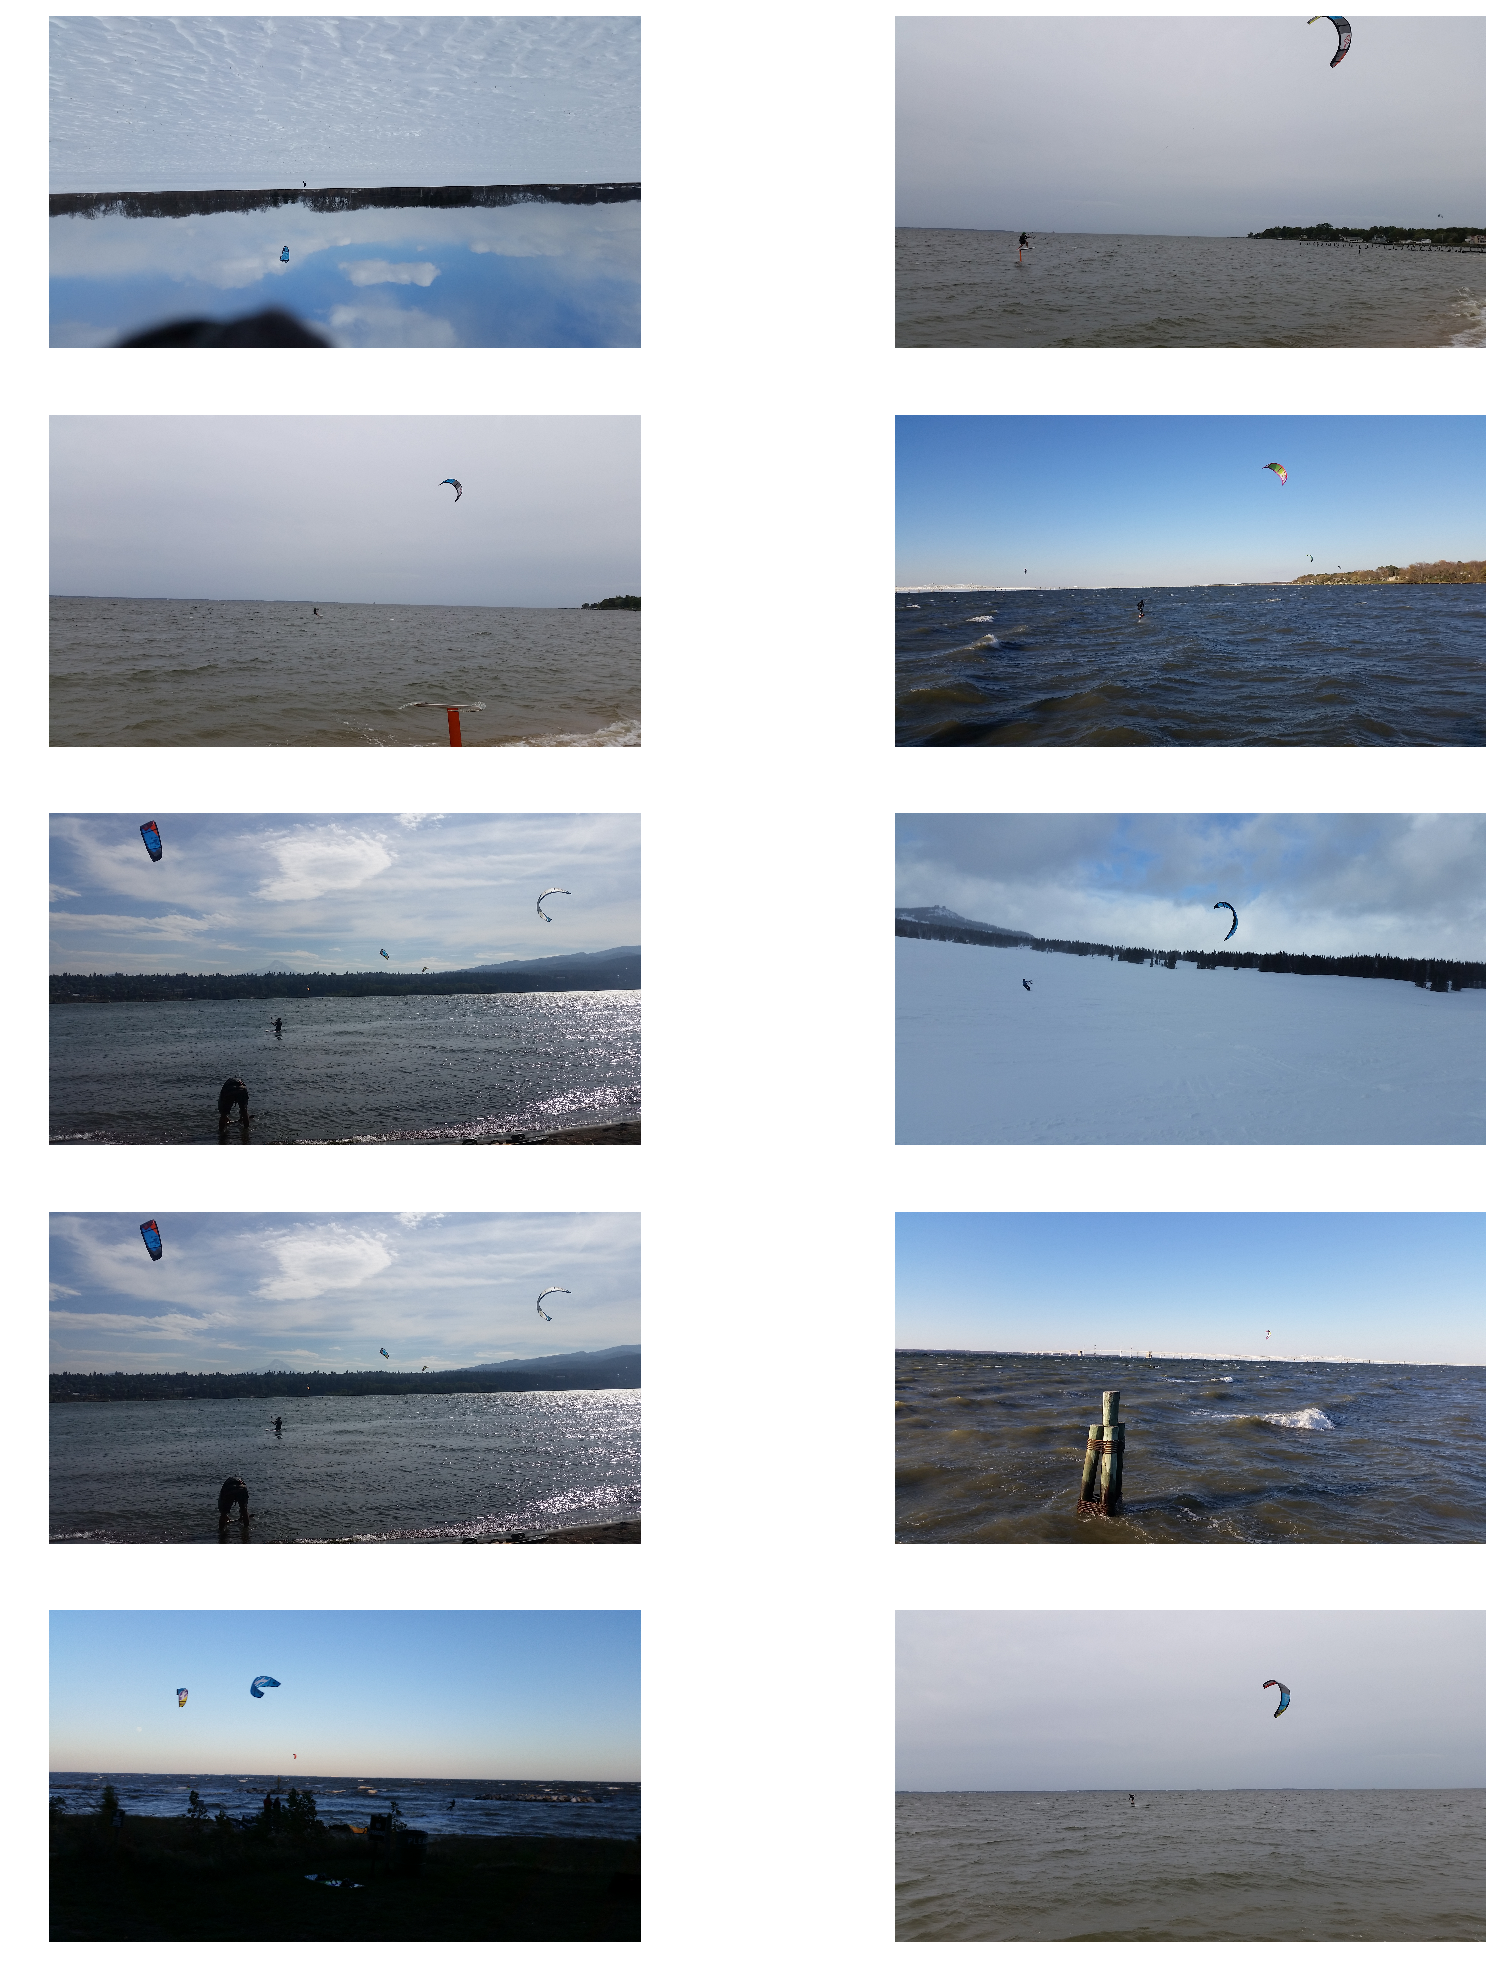

In [20]:
# Show a sample of raw images
s3_url = 'https://s3.amazonaws.com/beavercreekconsulting.com' + \
    '/kite-detector/training-kite-detector/data-set-one/raw-images/kite/%s'

filenames = ['20150219_151842.jpg', '20150925_174219.jpg', 
             '20150925_174115.jpg', '20151113_152505.jpg', 
             '20150827_153839.jpg', '20150225_145526.jpg', 
             '20150827_153839.jpg', '20151113_152122.jpg', 
             '20141006_180437.jpg', '20150925_174210.jpg']

plt.figure(figsize=(20, 30))
show_images(2, s3_url, filenames)

## Postive and negative examples
The raw images were seperated in to two sets: images that contain kites and images that do not.  The dataset size is 42 images that contain kites and 644 images that do not contain kites.

OpenCV [Cascade Classifier Training](http://docs.opencv.org/2.4/doc/user_guide/ug_traincascade.html) scripts were used to extract feature vectors and train the model.  

The positive images were created by cropping kites from the raw images.  A description file and the images are processed with the `opencv_createsamples` script to create the input vector/feature file.  The description file lists the images and location of the object in image coordinates.  A total of 62 positive images were created.

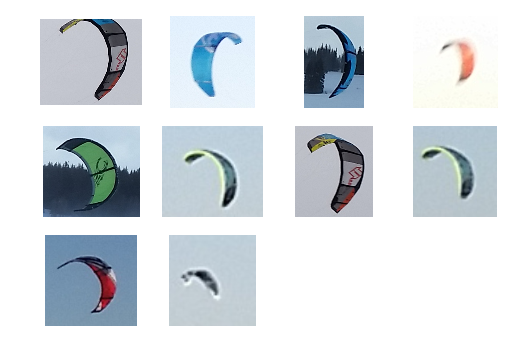

In [21]:
# Show positive examples

s3_url = 'https://s3.amazonaws.com/beavercreekconsulting.com' + \
    '/kite-detector/training-kite-detector/data-set-one/training/kite-crops/%s'
filenames = [
'20150925_174219_1.jpg', '20141006_180445_1.jpg',
'20150225_145522_1.jpg', '20141006_180443_3.jpg',
'20150225_145418_1.jpg', '20151113_152504_3.jpg',
'20150925_174220_1.jpg', '20151113_152502_3.jpg',
'20151113_152556_2.jpg', '20151113_152504_4.jpg'
]

show_images(4, s3_url, filenames)

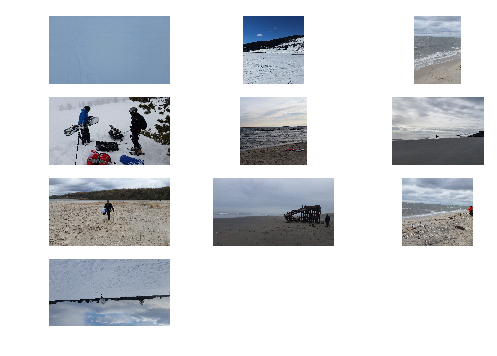

In [22]:
# Show negative examples

s3_url = 'https://s3.amazonaws.com/beavercreekconsulting.com' + \
    '/kite-detector/training-kite-detector/data-set-one/training/background/%s'
filenames = [
'20150225_145822.jpg', '20150201_104716.jpg', 
'20141101_155238.jpg', '20150225_154228.jpg', 
'20141129_152508.jpg', '20150102_101522.jpg', 
'20141101_160144.jpg', '20150828_153116.jpg', 
'20141101_155712.jpg', '20150219_151904.jpg'
]

show_images(3, s3_url, filenames)

## Test and train datasets

The images were further sub-divided into a training a test set.


|Image set | Positive Examples | Negative Examples|
|----------|-------------------|------------------|
|Raw | 42 | 644 |
|Training | 47 | 632 |
|Test | 12 | 51|

There are more positive examples that raw kite images since many raw images contained more than one kite.  More than one positive image is created by multiple crops of one raw image.

## Training the classifier
The following console trace is from the best training session:


```
marty@ubuntu:~/dev/kite-detector/training-one$   opencv_traincascade -data classifier.2 -vec kite-crop.dat -bg more-background-desciptions.txt -numPos 50 -numNeg 632 -numStages 10 -numThreads 4 -w 50 -h 50 -featureType HAAR  -maxFalseAlarmRate 0.25
PARAMETERS:
cascadeDirName: classifier.2
vecFileName: kite-crop.dat
bgFileName: more-background-desciptions.txt
numPos: 50
numNeg: 632
numStages: 10
precalcValBufSize[Mb] : 1024
precalcIdxBufSize[Mb] : 1024
acceptanceRatioBreakValue : -1
stageType: BOOST
featureType: HAAR
sampleWidth: 50
sampleHeight: 50
boostType: GAB
minHitRate: 0.995
maxFalseAlarmRate: 0.25
weightTrimRate: 0.95
maxDepth: 1
maxWeakCount: 100
mode: BASIC

===== TRAINING 0-stage =====
<BEGIN
POS count : consumed   50 : 50
NEG count : acceptanceRatio    632 : 1
Precalculation time: 14
+----+---------+---------+
|  N |    HR   |    FA   |
+----+---------+---------+
|   1|        1|        1|
+----+---------+---------+
|   2|        1|        1|
+----+---------+---------+
|   3|        1|        1|
+----+---------+---------+
|   4|        1| 0.469937|
+----+---------+---------+
|   5|        1| 0.085443|
+----+---------+---------+
END>
===== TRAINING 1-stage =====
<BEGIN
POS count : consumed   50 : 50
NEG count : acceptanceRatio    632 : 0.142182
Precalculation time: 14
+----+---------+---------+
|  N |    HR   |    FA   |
+----+---------+---------+
|   1|        1|        1|
+----+---------+---------+
|   2|        1|        1|
+----+---------+---------+
|   3|        1| 0.240506|
+----+---------+---------+
END>
Training until now has taken 0 days 0 hours 26 minutes 12 seconds.

```

The tail end of the training session:
```
===== TRAINING 9-stage =====
<BEGIN
POS count : consumed   50 : 50
NEG count : acceptanceRatio    632 : 5.50661e-06
Precalculation time: 14
+----+---------+---------+
|  N |    HR   |    FA   |
+----+---------+---------+
|   1|        1|        1|
+----+---------+---------+
|   2|        1|        1|
+----+---------+---------+
|   3|        1|        1|
+----+---------+---------+
|   4|        1| 0.634494|
+----+---------+---------+
|   5|        1| 0.393987|
+----+---------+---------+
|   6|        1|  0.21519|
+----+---------+---------+
END>
Training until now has taken 0 days 3 hours 22 minutes 48 seconds.
```

Traing stopped when the False Alarm rate dropped below 0.25.  Training took 3.5 hours on a laptop with an i5 processor.

## Results
OpenCV provides a script to evaluate test time accuracy.  The scripts could be run with this command
```
opencv_performance -data classifier.1/cascade.xml -info  test-images.txt
```
That command did not work for me.  I ended up scoring the test set by hand.

With a False Alarm rate around 21% on the traing set it's clear that the classifier has too many false positives.  The classifier does a good job of finding kites but does not reject non-kite images well enough.

## Conclusions

1. Building a decent kite detector can be done with a laptop and a good data set.
2. The classifier trained here does a poor job as it has a high false alarm rate.
3. To build a better classifier a larger data set is needed.
4. The dataset is small.  Better results could be obtained with data augmentation.

One additional conclusion is that the algorithms used here are not current state of the art.  A better approach is to use a Convolution Neural Network.
